In [18]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import utils.utils_funcs as uf
from subsets_analysis import Subsets
import pickle

## Loading the Data

In [20]:
# dictionary of mice and run numbers to analyse
run_dict = {
            'J064' : [10] 
           }

In [21]:
# local path to behaviour pickle files
# this takes a while to load so maybe should do some further caching in the future
pkl_path = os.path.expanduser('~/Documents/code/Vape/run_pkls/')

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

In [22]:
run = runs[0]  # just take the first session in the dict for now
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'flu_raw', 'frames_ms', 'frames_ms_pre', 'flu', 'spks', 'stat', 'paqio_frames'])

## Basic attributes of the run object

In [23]:
# toggle this cell on if you want to use raw fluoresence instead of processed (neuropil subtracted and Df/f)
# for i in range(len(runs)):
#     runs[i].flu = runs[i].flu_raw    

In [24]:
# processed (neuropil subtracted and Df/f) fluoresence matrix from first run
flu = run.flu
print('This run has {} cells and {} frames'.format(flu.shape[0], flu.shape[1]))

This run has 477 cells and 133121 frames


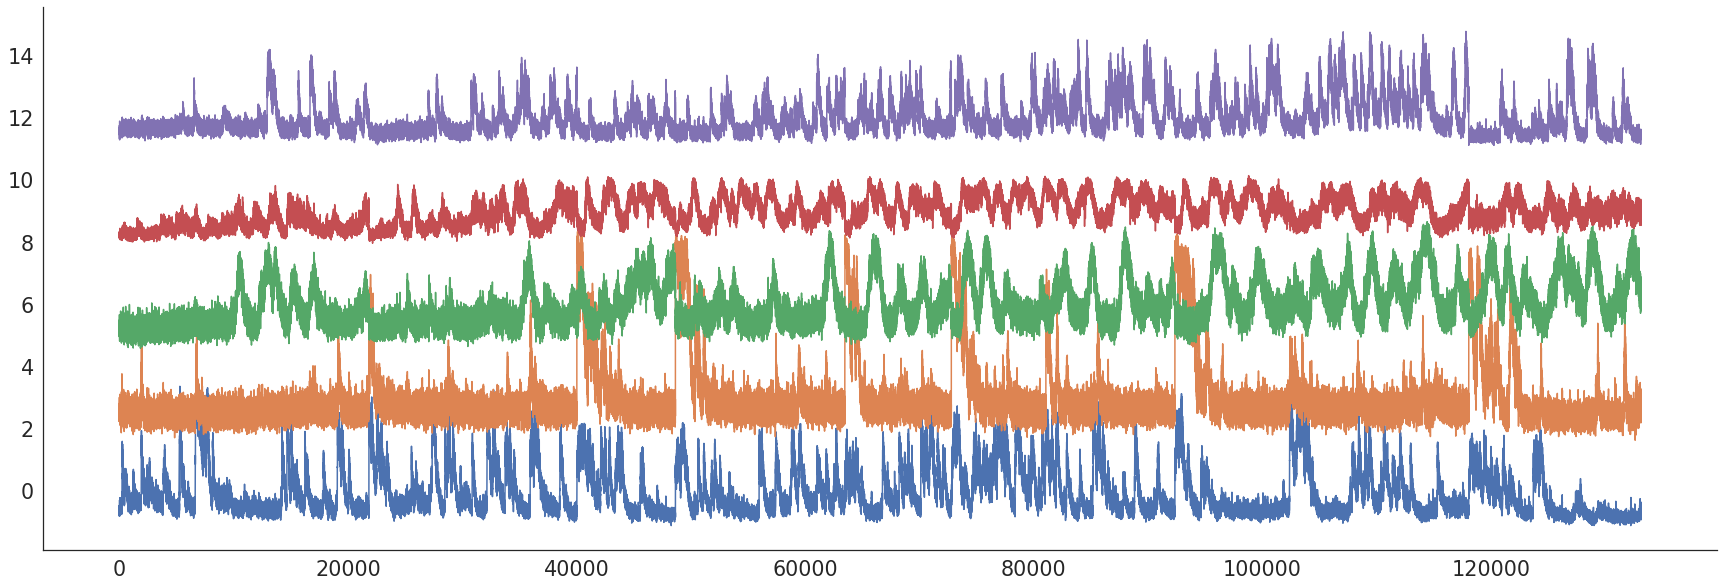

In [25]:
n_cells = 5
plt.figure(figsize=(30,10,))
for i in range(n_cells):
    plt.plot(run.flu[i,:]+i*3)

(250000, 300000)

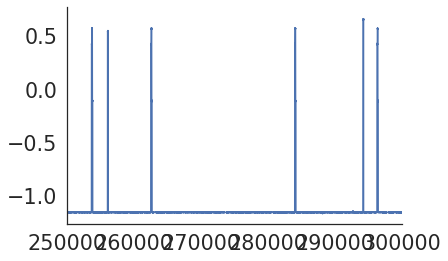

In [26]:
# the voltage sent to the uncaging x galvo is used to align to the start of trials
plt.plot(run.x_galvo_uncaging[::100])
plt.xlim((250000, 300000))

In [27]:
def get_trial_frames(clock, start, pre_frames, post_frames, fs=30, ye=False):

    # the frames immediately preceeding stim
    frame_idx = uf.closest_frame_before(clock, start)
    trial_frames = np.arange(frame_idx-pre_frames, frame_idx+post_frames)
    
    # is the trial outside of the frame clock
    is_beyond_clock = np.max(trial_frames) >= len(clock) or np.min(trial_frames) < 0
    
    if is_beyond_clock:
        return None
    
    frame_to_start = (start - clock[frame_idx]) / run.paq_rate  # time (s) from frame to trial_start
    frame_time_diff = np.diff(clock[trial_frames]) / run.paq_rate  # ifi (s)
    
    # did the function find the correct frame
    is_not_correct_frame = clock[frame_idx+1]  < start or clock[frame_idx] > start
    # the nearest frame to trial start was not during trial
    trial_not_running = frame_to_start > 1/fs
    # 
    frames_not_consecutive = np.max(frame_time_diff) > 1/(fs-1)
    
    if trial_not_running or frames_not_consecutive:
        return None
    return trial_frames

In [28]:
def build_flu_array(run, pre_frames=30, post_frames=80, fs=30):
    
    ''' Build an trial by trial fluoresence array of shape [n_cells x n_frames x n_trials]
        pre_frames = number of frames before stim to include in trial
        post_frames = number of frames after stim to include in trial
        fs = frame rate of imaging
        '''
    
    flu = run.flu
    # the frames that were actually imaged and the time (samples) that they occured
    clock = run.paqio_frames
    # the times of trial start in paq samples
    trial_start = uf.threshold_detect(run.x_galvo_uncaging, -0.5)
    # check that the number of trial starts detected by x galvo thresholding
    # matches the number of trials reported by pycontrol
    assert len(trial_start) == len(run.trial_start)

    for i, start in enumerate(trial_start):
        trial_frames = get_trial_frames(clock, start, pre_frames, post_frames)       

        if trial_frames is None:
            flu_trial = np.full([flu.shape[0], pre_frames+post_frames], np.nan)
        else:
            flu_trial = flu[:, trial_frames]
            
        if i == 0:
            flu_array = flu_trial
        else:
            
            flu_array = np.dstack((flu_array, flu_trial))


    return flu_array

In [29]:
pre_frames = 5
post_frames = 15
flu_array = build_flu_array(run, pre_frames=pre_frames, post_frames=post_frames)
flu_array.shape

(477, 20, 173)

In [30]:
# the outcome of the trial is stored in the run object
np.unique(run.outcome)

array(['cr', 'fp', 'hit', 'miss'], dtype='<U4')

In [31]:
# the number of cells stimmed on each trials 
# (currently requires Subsets class so could be simplified)
trial_subsets = Subsets(run).trial_subsets
np.unique(trial_subsets)

array([  0,   5,  10,  20,  30,  40,  50, 150])

In [32]:
# the indexes of hit trials where < 150 cells were stimmed (150 cells stim trials have
# much longer stim artifact)
hit_idx = np.where((run.outcome=='hit') & (trial_subsets!=150))[0]

Text(0, 0.5, 'DFOF')

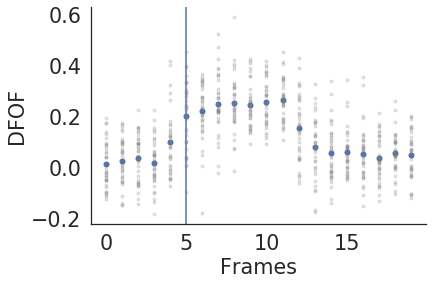

In [33]:
# plot the cell averaged result of these trials
trial_meaned = np.nanmean(flu_array[:,:,hit_idx], (0,2))
cell_meaned = np.nanmean(flu_array[:,:,hit_idx], 0)

plt.plot(trial_meaned, '.', markersize=10)
plt.axvline(pre_frames)
for trial in range(cell_meaned.shape[1]):
    plt.plot(cell_meaned[:, trial], '.', color='grey', alpha=0.2)
plt.xlabel('Frames')
plt.ylabel('DFOF')